# Business and data understanding - ethereum - v1

## Purpose
Entender o [DataverseNL (2021). Detection of illicit accounts over the Ethereum blockchain](http://doi.org/10.34894/GKAQYN).

# Setup

## Library import
We import all the required Python libraries

In [1]:
import os

# Data manipulation
import pandas as pd
import numpy as np

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib as plt

import missingno as msno
from pycaret.classification import ClassificationExperiment
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas
# pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.5f}'.format)
# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = 120

## Local library import
We import all the required local libraries libraries

In [2]:
os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade, check_for_equal_columns
os.chdir('./notebooks/')

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42


# Data import
We retrieve all the required data for the analysis.

In [4]:
try:
    df_raw = pd.read_parquet(INTERIM_FOLDER + 'ethereum_complete.pqt')
    print(f'PARQUET file loaded. Shape: {df_raw.shape}')
except FileNotFoundError as e:
    df_raw = pd.read_csv(RAW_FOLDER + 'ethereum_complete.csv')
    df_raw.drop(columns=['Index'], inplace=True)
   
    df_raw.to_parquet(INTERIM_FOLDER +  'ethereum_complete.pqt', index=False)
    print(f'EXCEL file loaded and PARQUET created. Shape: {df_raw.shape}')

PARQUET file loaded. Shape: (4681, 49)


In [5]:
display(df_raw.head(3))

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_sent_contracts,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_sent_addr.1,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_2_tnx,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,2.50105,1.34844,1.00087,11.27787,5.84292,0,0,0,16,17.52875,17.52978,0,0.00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,0.94751,0.76689,0.58541,0.94728,0.76635,0,0,0,4,1.53269,1.53378,0,0.00109,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,,Blockwell say NOTSAFU
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,0.81780,0.43961,0.50039,0.81751,0.65895,0,0,0,5,1.31790,1.31882,0,0.00092,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,,Blockwell say NOTSAFU


# Data evaluation

## Cardinality and null values

In [6]:
df_evaluation = df_raw.copy()

lst_duplicated_columns = [
    'ERC20_uniq_sent_addr.1', 'ERC20_avg_time_between_rec_2_tnx', 'ERC20_avg_val_sent_contract',
    'ERC20_max_val_sent_contract', 'ERC20_min_val_sent_contract',
]

df_evaluation.drop(columns=lst_duplicated_columns, inplace=True)

In [7]:
df_cardinalidade = cardinalidade(
    df_evaluation.drop(columns=['Address', 'FLAG'])
).sort_values(by='Proporção Nulos', ascending=False)
df_cardinalidade.sort_values(by=['Proporção Nulos'], ascending=False)

,Atributo,DType,Cardinalidade,Valores,Proporção Nulos
ERC20_most_rec_token_type,ERC20_most_rec_token_type,object,280,"[, , 0, A2A(B) STeX Exchange Token, ABCC invite, AI Gaming Coin, AICRYPTO, AION, ARP, ATLANT, ATN, AdEx, Aeternity, AirCoin, Amber, Amplify, An Etheal Promo, AppCoins, Aragon, ArtisTurba, Asobicoin promo, Authoreon, Authorship, Azbit, BAT, BAX, BBN, BCShareS, BOX Token, BUZCOIN, Bancor, Beauty Coin, BeautyChain, BigBang Game Coin Token, BinaryCoin, BitAir, BitClave, Bitcoin EOS, BizCoin, Blockwell say NOTSAFU, Blupee, Bounty, Bulleon Promo Token, CANDY, CGW, CIChain, CRYPTOPUNKS, Cai Token, CargoX, Carrots, Cashaa, Celer Network, Centra, ChainLink Token, Civic, CoinBene Coin, CoinDash, Coineal Token, CosmoCoin, Crypterium, Crypto.com, Cryptonex, CyberMiles, Cybereits Token, DALECOIN, DATAcoin, DCORP, DEBITUM, DEW, DGD, DICE, DIGIBYTE, DMTS, Dai Stablecoin v1.0, Dao.Casino, Data, Decentraland, Delphy Token, Digital Developers Fund Token, Dragon, Dropil, EBCoin, ECHARGE, ELF, EMO tokens, EOS, ERC20, ESSENTIA, EasyEosToken, Edgeless, ElectrifyAsia, Electronic Energy Coin, Energem, EnjinCoin, Enumivo, Ethbits, EtherEcash, Ethereum, Ethos, Everest, ...]",0.17859
ERC20_most_sent_token_type,ERC20_most_sent_token_type,object,172,"[, , '', 0, 21Million, AION, ARBITRAGE, AVT, AdEx, Adshares, Aeternity, AirToken, Aragon, Authorship, BAT, BCShareS, BNB, BTOCoin, BUZCOIN, Bancor, BinaryCoin, BitDice, BizCoin, Blackmoon Crypto Token, Bounty0x, Brickblock, Bytom, CANDY, CRYPTOPUNKS, CarTaxi, Cashaa, ChainLink Token, CharterCoin, Civic, Cofoundit, CoinDash, Crypterium, Crypto.com, DADI, DATAcoin, DGD, DICE, Dao.Casino, Decent.Bet Token, Decentraland, Digital Developers Fund Token, Digix Gold Token, EDT, EOS, ERC20, ETHWrapper, Electronic Energy Coin, EnjinCoin, Ether, Ethos, Fair Token, Fantom Token, Feed, Fortecoin, Friendz Coin, FunFair, GECoin, GRID, Gemini dollar, Gnosis, Golem, Guppy, Happy Coin, Hawala, Humaniq, HuobiPoolToken, HuobiToken, Hydro, IBCCoin, ICO, ICON, ICONOMI, IDICE, IOSToken, IOT Chain, IUNGO, Identity Hub Token, KickCoin, KyberNetwork, Litecoin One, Livepeer Token, Loopring, Lucky Token, Lunyr, MCAP, MEX, Magna, Master Coin, Mavrodi, Merculet, Mithril Token, MobileGo, Monetha, NOAHCOIN, NaN, ...]",0.17731
ERC20_min_val_rec,ERC20_min_val_rec,float64,538,"[0.0, 990000.0]",0.17710
Total_ERC20_tnxs,Total_ERC20_tnxs,float64,199,"[0.0, 10000.0]",0.17710
ERC20_uniq_rec_token_name,ERC20_uniq_rec_token_name,float64,100,"[0.0, 435.0]",0.17710
ERC20_uniq_sent_token_name,ERC20_uniq_sent_token_name,float64,58,"[0.0, 125.0]",0.17710
ERC20_avg_val_sent,ERC20_avg_val_sent,float64,414,"[0.0, 56147560976.0]",0.17710
ERC20_min_val_sent,ERC20_min_val_sent,float64,175,"[0.0, 100000000.0]",0.17710
ERC20_avg_val_rec,ERC20_avg_val_rec,float64,1266,"[0.0, 17241810275.0]",0.17710
ERC20_max_val_rec,ERC20_max_val_rec,float64,990,"[0.0, 1000000000000.0]",0.17710


In [8]:
# List of columns with cardinality equals to 1
df_cardinalidade.loc[df_cardinalidade['Cardinalidade']<=2, :]

,Atributo,DType,Cardinalidade,Valores,Proporção Nulos
ERC20_avg_time_between_contract_tnx,ERC20_avg_time_between_contract_tnx,float64,2,"[nan, 0.0]",0.17710
ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_sent_tnx,float64,2,"[nan, 0.0]",0.17710
ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_tnx,float64,2,"[nan, 0.0]",0.17710
total_ether_sent_contracts,total_ether_sent_contracts,object,1,[0],0.00000
min_value_sent_to_contract,min_value_sent_to_contract,object,1,[0],0.00000
max_val_sent_to_contract,max_val_sent_to_contract,object,1,[0],0.00000
avg_value_sent_to_contract,avg_value_sent_to_contract,object,1,[0],0.00000


In [9]:
lst_unitary_columns = df_cardinalidade[df_cardinalidade['Cardinalidade']==1].index.tolist()
lst_unitary_columns

['total_ether_sent_contracts',
 'min_value_sent_to_contract',
 'max_val_sent_to_contract',
 'avg_value_sent_to_contract']

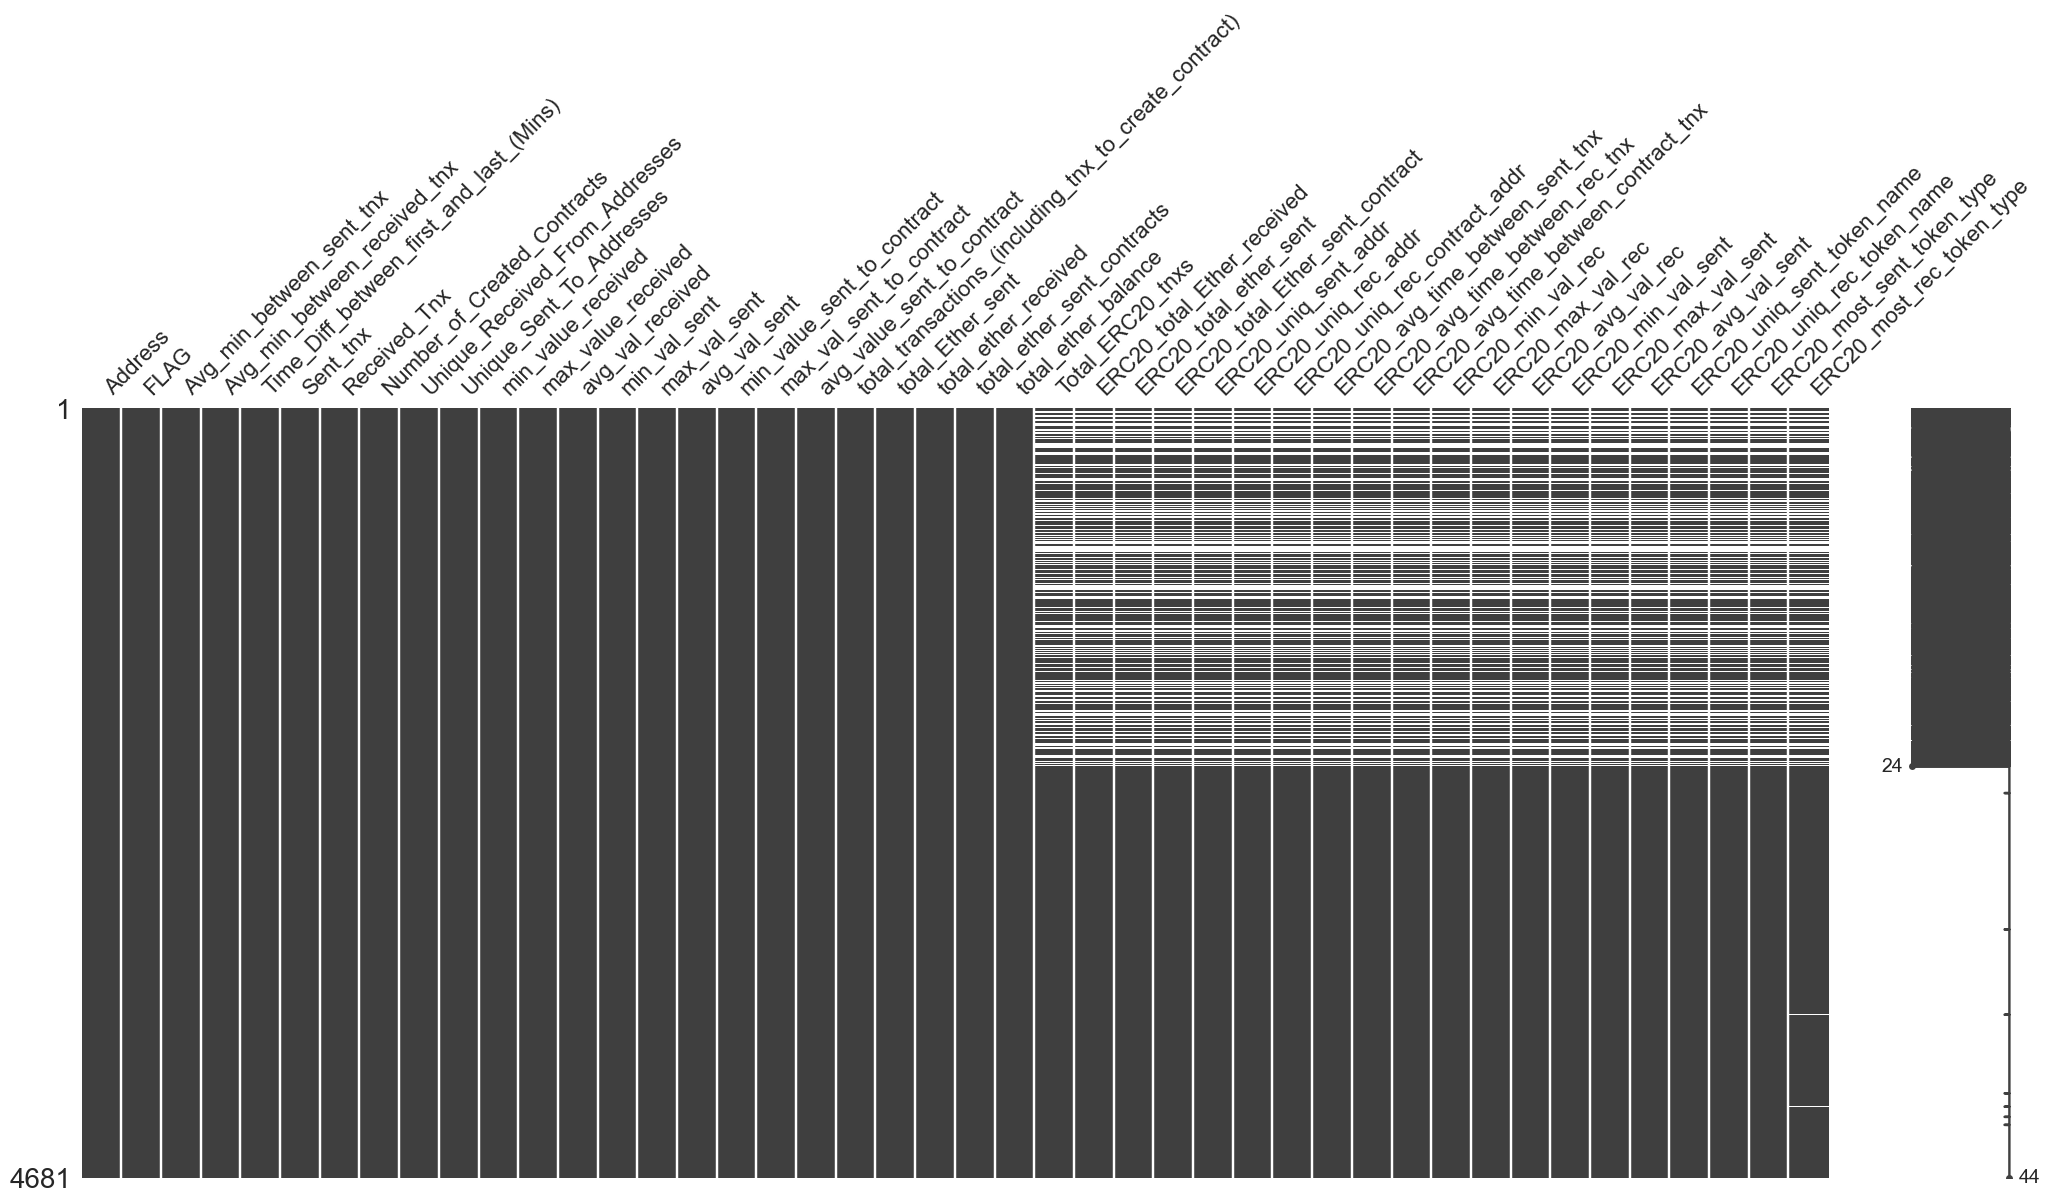

In [10]:
msno.matrix(df_evaluation);

## Checking columns that are equal

In [11]:
check_for_equal_columns(df_evaluation)

,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_ether_sent_contracts,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_contract_tnx
min_value_sent_to_contract,1,1,1,1,0,0,0
max_val_sent_to_contract,1,1,1,1,0,0,0
avg_value_sent_to_contract,1,1,1,1,0,0,0
total_ether_sent_contracts,1,1,1,1,0,0,0
ERC20_avg_time_between_sent_tnx,0,0,0,0,1,1,1
ERC20_avg_time_between_rec_tnx,0,0,0,0,1,1,1
ERC20_avg_time_between_contract_tnx,0,0,0,0,1,1,1


In [12]:
lst_equal_columns = check_for_equal_columns(df_evaluation).index.tolist()
lst_equal_columns_keep = check_for_equal_columns(df_evaluation).drop_duplicates(keep='last').index.values.tolist()

for column in lst_equal_columns_keep:
    lst_equal_columns.remove(column)

lst_equal_columns

['min_value_sent_to_contract',
 'max_val_sent_to_contract',
 'avg_value_sent_to_contract',
 'ERC20_avg_time_between_sent_tnx',
 'ERC20_avg_time_between_rec_tnx']

## Categorical features

In [34]:
df_evaluation_categorical = df_evaluation.select_dtypes(include='object').drop(columns='Address')
df_evaluation_categorical.head()

,ERC20_most_sent_token_type,ERC20_most_rec_token_type
0,None,None
1,,Blockwell say NOTSAFU
2,,Blockwell say NOTSAFU
3,OCoin,OCoin
4,None,None


In [56]:
a

In [57]:
type(a)

NoneType

### ERC20_most_sent_token_type

In [71]:
df_evaluation_categorical.loc[:, 'ERC20_most_sent_token_type'].value_counts()[df_evaluation_categorical.loc[:, 'ERC20_most_sent_token_type'].value_counts() > 3]

                                 1794
0                                1544
blockwell.ai KYC Casper Token      65
OmiseGO                            47
EOS                                40
Golem                              27
StatusNetwork                      22
Tronix                             15
Qtum                               12
BAT                                11
TenXPay                            11
Bancor                              7
VeChain                             7
Patientory                          6
Livepeer Token                      6
Humaniq                             6
minereum                            5
Reputation                          5
Cofoundit                           4
XENON                               4
Crypto.com                          4
Veritaseum                          4
AdEx                                4
Gnosis                              4
Trustcoin                           4
Ether                               4
Name: ERC20_

In [59]:
df_evaluation_categorical.loc[
    (df_evaluation_categorical['ERC20_most_sent_token_type'] is None) |
    (df_evaluation_categorical['ERC20_most_sent_token_type'] == ' ') |
    (df_evaluation_categorical['ERC20_most_sent_token_type'] == '0')
    , 'ERC20_most_sent_token_type'
].value_counts()

     1794
0    1544
Name: ERC20_most_sent_token_type, dtype: int64

### ERC20_most_rec_token_type

In [72]:
df_evaluation_categorical.loc[:, 'ERC20_most_rec_token_type'].value_counts()[df_evaluation_categorical.loc[:, 'ERC20_most_rec_token_type'].value_counts() > 3]

0                                     1544
Blockwell say NOTSAFU                  779
OmiseGO                                355
VIU                                     81
GSENetwork                              80
INS Promo                               54
Livepeer Token                          53
blockwell.ai KYC Casper Token           47
AICRYPTO                                45
EOS                                     37
Free BOB Tokens - BobsRepair.com        37
ERC20                                   35
Golem                                   33
XENON                                   29
Tronix                                  26
                                        24
An Etheal Promo                         20
KickCoin                                19
DATAcoin                                19
StatusNetwork                           18
Lino                                    13
Yooba token                             12
WinETHFree                              12
SAFE.AD - 2

## Auto EDA with ydata

In [13]:
# profile = ProfileReport(
#     df_evaluation.sample(50, random_state=RANDOM_STATE),
#     title="Profiling Report")

# # profile.to_file(REPORTS_FOLDER + 'data_analysis_report.html')
# profile.to_widgets()

## Conclusion

1. O *dataset* original continha 49 atributos. Excluindo-se as colunas de **Address** e **FLAG**, chegamos a 47. Há 5 colunas a mais do que o indicado no artigo. Isso deve-se:
    - **ERC20_uniq_sent_addr.1** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_uniq_sent_addr**.
    - **ERC20_avg_time_between_rec_2_tnx** NÃO existe originalmente, talvez tenha havido alguma duplicação sem transformação da coluna **ERC20_avg_time_between_rec_tnx**.
    - **ERC20_avg_val_sent_contract** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_avg_val_sent**
    - **ERC20_max_val_sent_contract** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_max_val_sent**
    - **ERC20_min_val_sent_contract** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_min_val_sent**

---

2. Colunas com cardinalidade igual a 1. Quatro colunas possuem cardinalidade igual a 1 e, portanto, NÃO adicionam nenhuma informação para a classificação das carteiras:
    - **'avg_value_sent_to_contract'**,
    - **'max_val_sent_to_contract'**,
    - **'total_ether_sent_contracts'**,
    - **'min_value_sent_to_contract'**

---

3. Há 2 grupos de colunas que são idênticos e, portanto, podemos remover os idênticos e manter apenas um de cada grupo:
    - **'min_value_sent_to_contract'**, **'max_val_sent_to_contract'**, **'avg_value_sent_to_contract'**, **'total_ether_sent_contracts'** -> Manteremos **'total_ether_sent_contracts'**
    - **'ERC20_avg_time_between_sent_tnx'**, **'ERC20_avg_time_between_rec_tnx'**, **'ERC20_avg_time_between_contract_tnx'** -> Manteremos **'ERC20_avg_time_between_contract_tnx'**


# Data cleaning

1. Remove duplicated registries
2. Remove duplicated columns
3. Remove constant columns
4. Remove equal columns

## Removing duplicated registries

In [14]:
df_cleaned = df_raw.copy()

In [15]:
df_cleaned.drop_duplicates(inplace=True)

print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated rows: {df_cleaned.shape}')

Shape before data cleasing: (4681, 49)
After dropping duplicated rows: (4677, 49)


## Removing duplicated columns

In [16]:
df_cleaned.drop(columns=lst_duplicated_columns, inplace=True)

print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated columns: {df_cleaned.shape}')

Shape before data cleasing: (4681, 49)
After dropping duplicated columns: (4677, 44)


## Removing constant columns

In [17]:
df_cleaned.drop(columns=lst_unitary_columns, inplace=True)

print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated columns: {df_cleaned.shape}')

Shape before data cleasing: (4681, 49)
After dropping duplicated columns: (4677, 40)


## Removing equal columns

In [18]:
for column in lst_equal_columns:
    try:
        df_cleaned.drop(columns=column, inplace=True)
    except:
        print(f"'{column}' was exluded before.")

print(30*'-')
print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated columns: {df_cleaned.shape}')

'min_value_sent_to_contract' was exluded before.
'max_val_sent_to_contract' was exluded before.
'avg_value_sent_to_contract' was exluded before.
------------------------------
Shape before data cleasing: (4681, 49)
After dropping duplicated columns: (4677, 38)


# Testing with pycaret

## All features

In [19]:
test_size = 0.15
train_size = 1 - test_size

lst_test_sample = df_cleaned.sample(int(test_size*len(df_cleaned)), random_state=RANDOM_STATE).index.values
lst_train_sample = df_cleaned.drop(index=lst_test_sample).index.values

print(f"""
test_size: {test_size}
test_sample (registries): {len(lst_test_sample)}

train_size: {train_size}
train_sample (registries): {len(lst_train_sample)}
""")


test_size: 0.15
test_sample (registries): 701

train_size: 0.85
train_sample (registries): 3976



In [20]:
df_cleaned.loc[lst_train_sample, :].head()

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,2.50105,1.34844,1.00087,11.27787,5.84292,16,17.52875,17.52978,0.00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,0.94751,0.76689,0.58541,0.94728,0.76635,4,1.53269,1.53378,0.00109,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000,,Blockwell say NOTSAFU
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,0.81780,0.43961,0.50039,0.81751,0.65895,5,1.31790,1.31882,0.00092,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000,,Blockwell say NOTSAFU
3,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,1,2300.37000,65.10000,73091.00000,29,98,0,89,26,0.00078,15.72907,0.38322,0.00000,36.70000,1.31496,127,38.13377,37.55605,-0.57772,96.00000,142677.38290,120354.76840,0.00000,6.00000,55.00000,37.00000,0.00000,0.00000,26436.08100,1954.48470,0.00000,81324.07460,5232.81602,22.00000,37.00000,OCoin,OCoin
4,0x005b9f4516f8e640bbe48136901738b323c53b00,1,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [21]:
exp = ClassificationExperiment()
exp.setup(
    df_cleaned.loc[lst_train_sample, :].drop(columns=['Address']),
    target='FLAG', train_size=train_size, session_id=RANDOM_STATE
);

,Description,Value
0,Session id,42
1,Target,FLAG
2,Target type,Binary
3,Original data shape,"(3976, 37)"
4,Transformed data shape,"(3976, 37)"
5,Transformed train set shape,"(3379, 37)"
6,Transformed test set shape,"(597, 37)"
7,Numeric features,34
8,Categorical features,2
9,Rows with missing values,18.1%


In [22]:
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9840,0.9984,0.9766,0.9892,0.9828,0.9679,0.9680,0.9540
catboost,CatBoost Classifier,0.9837,0.9986,0.9773,0.9879,0.9826,0.9673,0.9674,0.9350
rf,Random Forest Classifier,0.9828,0.9983,0.9760,0.9873,0.9816,0.9655,0.9656,0.8650
lightgbm,Light Gradient Boosting Machine,0.9819,0.9983,0.9766,0.9848,0.9806,0.9637,0.9638,1.0330
xgboost,Extreme Gradient Boosting,0.9811,0.9981,0.9747,0.9848,0.9797,0.9619,0.9620,0.7780
gbc,Gradient Boosting Classifier,0.9796,0.9980,0.9735,0.9829,0.9781,0.9590,0.9591,1.4780
ada,Ada Boost Classifier,0.9772,0.9973,0.9760,0.9757,0.9758,0.9543,0.9544,0.8950
dt,Decision Tree Classifier,0.9639,0.9641,0.9678,0.9561,0.9618,0.9276,0.9279,0.6620
ridge,Ridge Classifier,0.9580,0.0000,0.9735,0.9393,0.9561,0.9158,0.9164,0.6550
lda,Linear Discriminant Analysis,0.9580,0.9876,0.9735,0.9393,0.9561,0.9158,0.9164,0.8160


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [23]:
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)

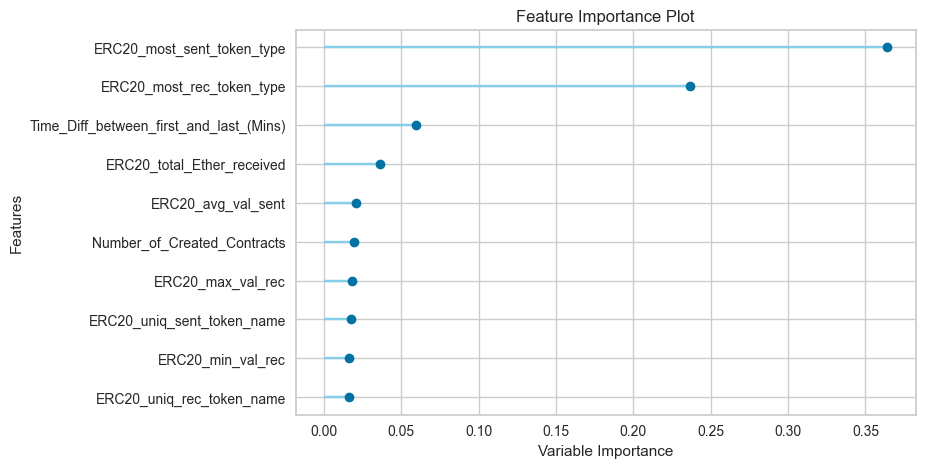

In [24]:
exp.plot_model(best, plot='feature')

## Only numerical features

,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,...,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
0,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,...,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000
2,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,...,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000
3,1,2300.37000,65.10000,73091.00000,29,98,0,89,26,0.00078,...,37.00000,0.00000,0.00000,26436.08100,1954.48470,0.00000,81324.07460,5232.81602,22.00000,37.00000
4,1,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4673,0,33.13000,49.15000,354842.65000,8532,1468,0,403,62,0.00253,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4675,0,0.00000,8643.53000,60504.72000,0,7,1,3,0,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4676,0,0.00000,0.00000,1.52000,1,1,0,1,1,4.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4678,0,0.00000,0.00000,173.97000,1,1,0,1,1,0.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [28]:
exp = ClassificationExperiment()
exp.setup(
    df_cleaned.loc[lst_train_sample, df_cleaned.select_dtypes(exclude=['object']).columns],
    target='FLAG', train_size=train_size, session_id=RANDOM_STATE
);

,Description,Value
0,Session id,42
1,Target,FLAG
2,Target type,Binary
3,Original data shape,"(3976, 35)"
4,Transformed data shape,"(3976, 35)"
5,Transformed train set shape,"(3379, 35)"
6,Transformed test set shape,"(597, 35)"
7,Numeric features,34
8,Rows with missing values,17.9%
9,Preprocess,True


In [29]:
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9799,0.9983,0.9785,0.9787,0.9785,0.9596,0.9597,6.6690
xgboost,Extreme Gradient Boosting,0.9796,0.9980,0.9785,0.9780,0.9782,0.9590,0.9590,0.9720
lightgbm,Light Gradient Boosting Machine,0.9793,0.9983,0.9804,0.9756,0.9780,0.9584,0.9585,1.0820
gbc,Gradient Boosting Classifier,0.9743,0.9972,0.9741,0.9712,0.9726,0.9483,0.9484,1.3390
rf,Random Forest Classifier,0.9742,0.9976,0.9703,0.9748,0.9725,0.9483,0.9484,1.0610
ada,Ada Boost Classifier,0.9737,0.9964,0.9697,0.9741,0.9719,0.9471,0.9472,0.8510
et,Extra Trees Classifier,0.9716,0.9965,0.9672,0.9722,0.9696,0.9429,0.9431,1.0040
dt,Decision Tree Classifier,0.9606,0.9605,0.9577,0.9585,0.9580,0.9210,0.9211,0.7620
knn,K Neighbors Classifier,0.8908,0.9495,0.8813,0.8865,0.8835,0.7807,0.7814,0.7610
lr,Logistic Regression,0.7591,0.8045,0.5043,0.9682,0.6489,0.5011,0.5637,2.0760


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

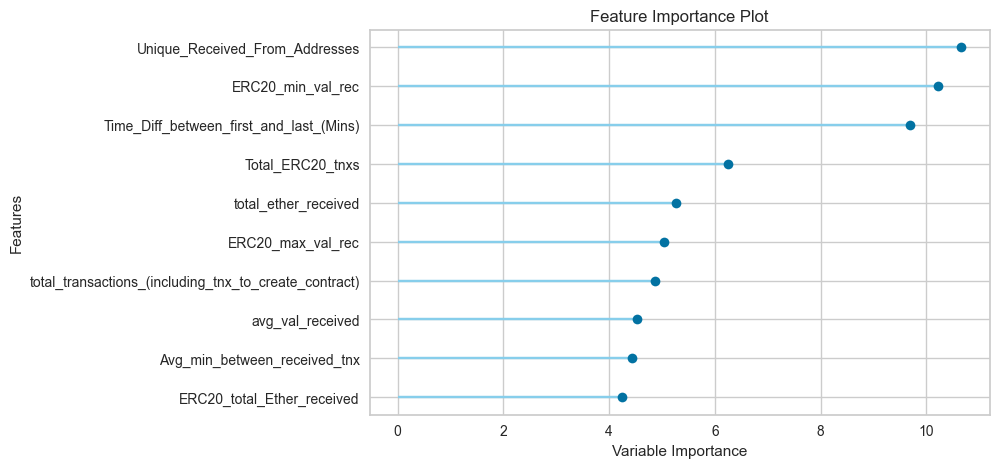

In [30]:
exp.plot_model(best, plot='feature')